# 1. Mejoramiento iterativo y estimación de número de condicionamiento.

## 1.1. Mejoramiento iterativo

Supongamos que se computa la solución de $\mathbf{Ax} = \mathbf{b}$ mediante la 
factorización con pivoteo parcial $\mathbf{PA} = \mathbf{LU}$. Podemos mejorar 
de forma iterativa la solución $\mathbf{\hat x}$ de la siguiente forma:

    r = b-Ax (precisión más alta)
    Resolver Ly = Pr
    Resolver Uz = y
    x_new = x + z

El algoritmo de mejora iterativa cumple con la siguiente heurística: Si
$\epsilon_m$ representa la presición de máquina y satisface $\epsilon_m = 
10^{-d}$ y $\kappa_{\infty}(\mathbf{A}) \approx 10^q$, entonces después de 
$k$ ejecuciones del algoritmo de mejora iterativa, $\mathbf{x}$ tiene 
aproximadamente $\min\{d, k(d-q)\}$ dígitos correctos, si el cómputo del 
residual se realiza con $\epsilon_m^2$ dígitos de presición. Note que en cada 
iteración del algoritmo, se realizan $\mathcal{O}(n^2)$ operaciones, en 
contraste con el costo de la factorización LU de $\mathcal{O}(n^3)$ 
operaciones.

## 1.2. Estimación del número de condicionamiento

De los teoremas vistos en clases, se puede ver que la eliminación Gaussiana 
produce $\mathbf{\hat x}$ tal que

$$
\frac{\|\mathbf{\hat x} - \mathbf{x}\|_{\infty}}{\|\mathbf{x}\|_{\infty}} 
\approx \epsilon_m \kappa_{\infty}(\mathbf{A})
$$

Este algoritmo de mejora iterativa se puede utilizar para estimar el 
número de condicionamiento de una matriz $\mathbf{A}$ en $\mathcal{O}(n^2)$ 
operaciones, asumiendo que se cuenta con la factorización $\mathbf{PA} = 
\mathbf{LU}$. Se basa en la siguiente heurística:

$$
\epsilon_m \kappa_{\infty}(\mathbf{A}) \approx \|\mathbf{z}\|_{\infty}/| / 
\|\mathbf{x}\|_{\infty}
$$

Otra forma de estimar $\kappa_{\infty}(\mathbf{A})$ se basa en la siguiente 
implicancia:

$$
\mathbf{Ay} = \mathbf{d} \Rightarrow \|\mathbf{A}^{-1}\|_{\infty} \geq 
\|\mathbf{y}\|_{\infty}/\|\mathbf{d}\|_{\infty}
$$

Para una matriz triangular superior $\mathbf{T}$, el siguiente algoritmo 
computa un vector unitario (en la norma $\|\cdot\|_{\infty}$) $\mathbf{y}$ y 
un escalar $\kappa$ tal que $\|\mathbf{Ty}\|_{\infty} 
\approx 1/\|\mathbf{T}^{-1}\|_{\infty}$ y $\kappa \approx 
\kappa_{\infty}(\mathbf{T})$:

    p(1:n) = 0
    for k=n:-1:1 do
        y(k)+ = (1-p(k))/T(k, k)
        y(k)- = (-1-p(k))/T(k, k)
        p(k)+ = p(1:k-1) + T(1:k-1, k)y(k)+
        p(k)- = p(1:k-1) + T(1:k-1, k)y(k)-
        if |y(k)+| + ||p(k)+||_1 >= |y(k)-| + ||p(k)-||_1 do
            y(k) = y(k)+
            p(1:k-1) = p(k)+
        else
            y(k) = y(k)-
            p(1:k-1) = p(k)-
        end if
    end for
    k = ||y||_{oo} ||T||_{oo}
    y = y/||y||_{oo}

Luego, si contamos con la factorización $\mathbf{PA} = \mathbf{LU}$, entonces 
podemos estimar el número de condicionamiento de la siguiente forma:

1. Aplicar el algoritmo anterior a $\mathbf{U}^T$.
2. Resolver los sistemas triangulares $\mathbf{L}^T\mathbf{r} = \mathbf{y}$, 
$\mathbf{Lw} = \mathbf{Pr}$, y $\mathbf{Uz} = \mathbf{w}$
3. Set $\hat \kappa_{\infty} = \|\mathbf{A}\|_{\infty}\|\mathbf{z}\|_{\infty} / 
\|\mathbf{r}\|_{\infty}$

Podemos comprobarlo con el siguiente código:

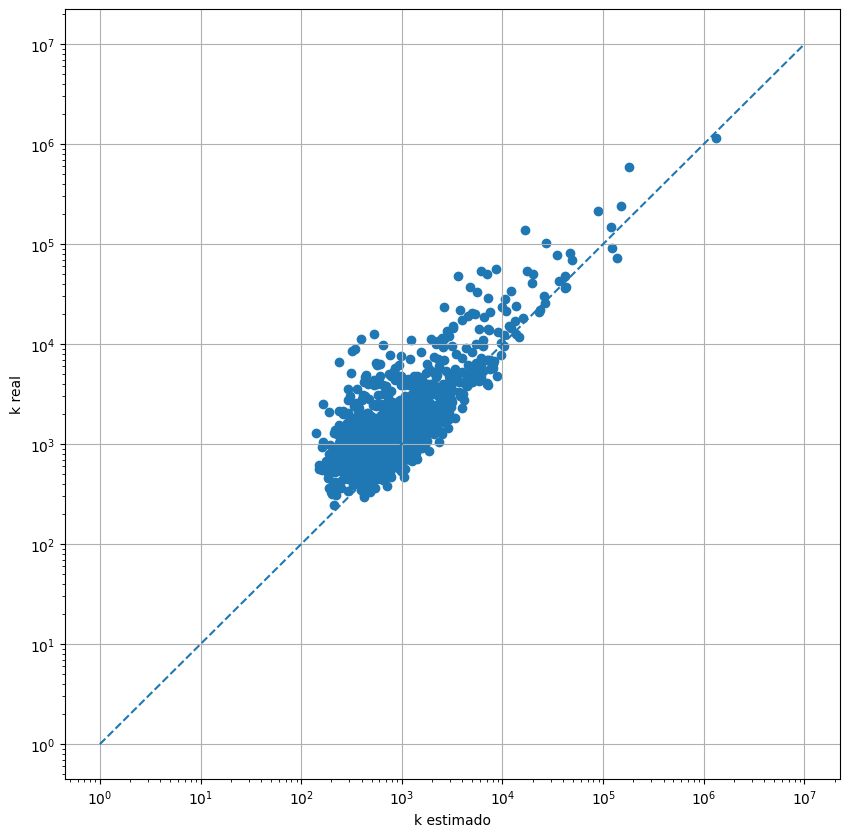

In [5]:
import scipy.linalg as spl
import numpy as np

def cond_estimation_lower(T):
    n, _ = T.shape
    p = np.zeros(n)
    y = np.zeros(n)
    for idx in range(n):
        yp = (1-p[idx])/T[idx, idx]
        ym = (-1-p[idx])/T[idx, idx]
        pp = p[idx+1:] + T[idx+1:, idx] * yp
        pm = p[idx+1:] + T[idx+1:, idx] * ym
        if abs(yp) + np.linalg.norm(pp, 1) >= abs(ym) + np.linalg.norm(pm, 1):
            y[idx] = yp
            p[idx+1:] = pp
        else:
            y[idx] = ym
            p[idx+1:] = pm
    k = np.linalg.norm(y, np.inf) * np.linalg.norm(T, np.inf)
    # y = y/np.linalg.norm(y, np.inf)
    return k, y

def cond_estimation(A):
    P, L, U = spl.lu(A)
    P = P.T
    k0, y = cond_estimation_lower(U.T)
    r = np.linalg.solve(L.T, y)
    w = np.linalg.solve(L, P.dot(r))
    z = np.linalg.solve(U, w)
    k = np.linalg.norm(A, np.inf)*np.linalg.norm(z, np.inf)/np.linalg.norm(r, np.inf)
    return 10*k

y_target = []
y_pred = []

for idx in range(1000):
    A = 100*np.random.randn(50, 50)
    y_target.append(np.linalg.cond(A, np.inf))
    y_pred.append(cond_estimation(A))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
xj = np.arange(1, 1e7, step=1e4)
ax.scatter(y_pred, y_target)
ax.plot(xj, xj, "--")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("k estimado")
ax.set_ylabel("k real")
ax.grid()

# 2. Matrices sparse

Suponga que $\mathbf{A}$ satisface la misma condición que en el enunciado 
anterior y que tiene ancho de banda igual a $2p+1$. ¿Qué se puede decir sobre 
los patrones de sparcity de $\mathbf{L}$ y $\mathbf{U}$? Experimente con 
ejemplos numéricos y los algoritmos sin pivotear y con pivoteo parcial.

Text(0.5, 1.0, 'U')

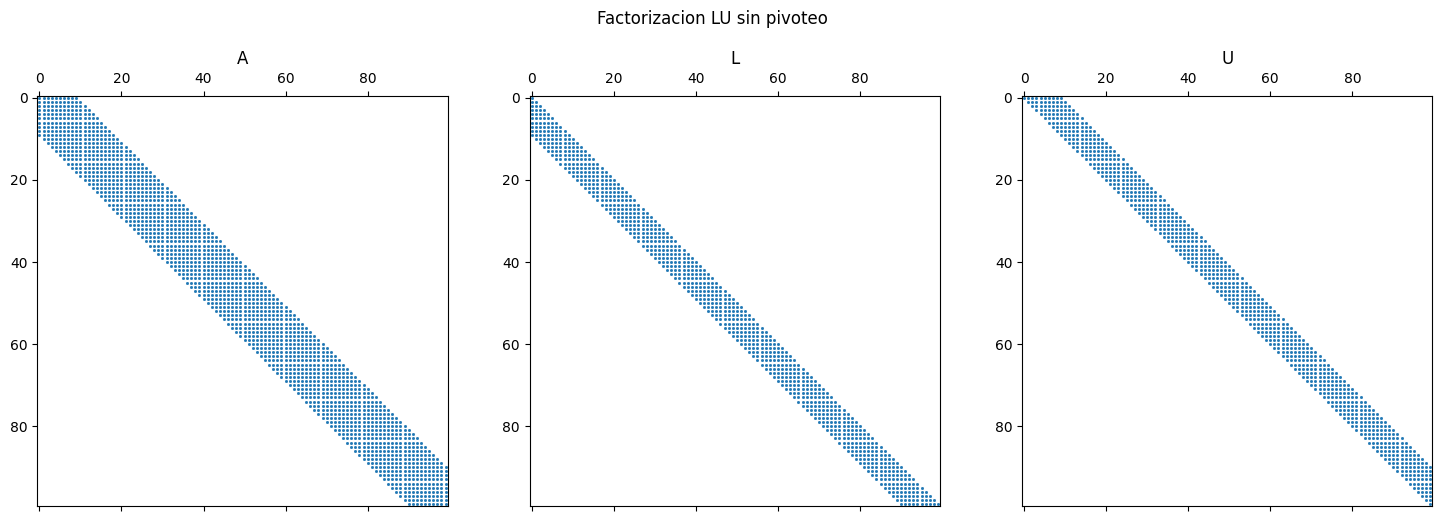

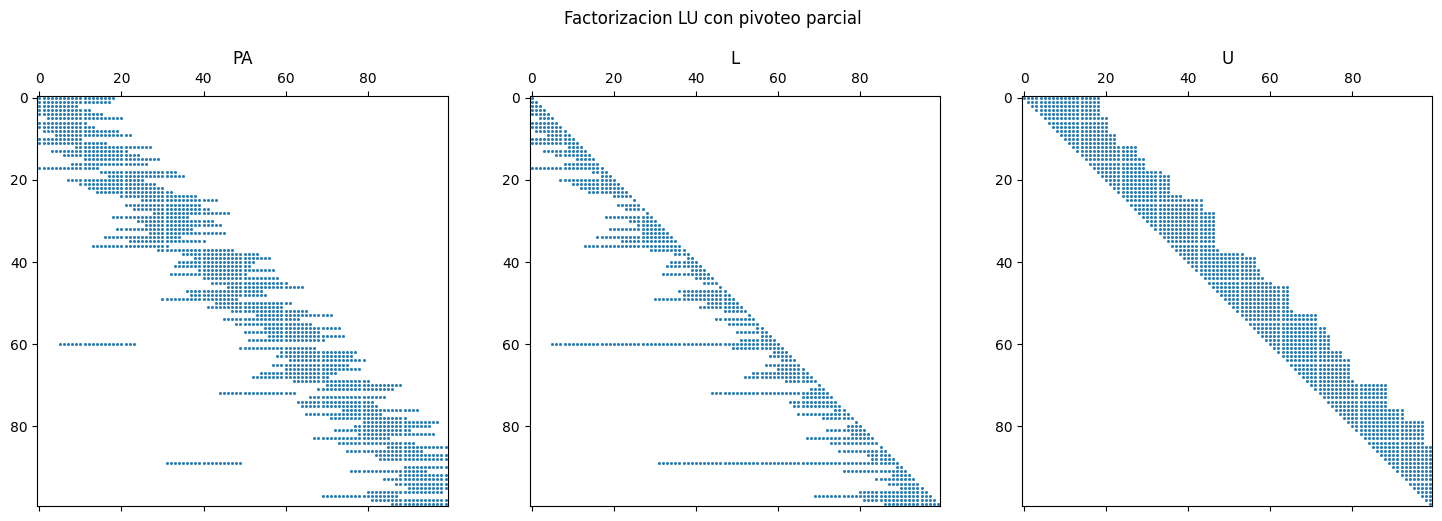

In [6]:
def LUdecomp(b):
    a = np.copy(b)
    n = len(a)
    L = np.eye(a.shape[0])
    U = np.zeros(a.shape)
    for k in range(0,n-1):
        for i in range(k+1,n):
            if a[i,k] != 0.0:
                lam = a [i,k]/a[k,k]
                a[i,k+1:n] = a[i,k+1:n] - lam*a[k,k+1:n]
                a[i,k] = lam
    L += np.tril(a, k=-1)
    U = np.triu(a)
    return L, U

n = 100
A = np.diag(np.random.randn(n))
for idx in range(1, 10):
    d1 = np.random.randn(100-idx)
    A += np.diag(d1, k=idx)
    d2 = np.random.randn(100-idx)
    A += np.diag(d2, k=-idx)

L, U = LUdecomp(A)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Factorizacion LU sin pivoteo")
axs[0].spy(A, markersize=1)
axs[0].set_title("A")
axs[1].spy(L, markersize=1)
axs[1].set_title("L")
axs[2].spy(U, markersize=1)
axs[2].set_title("U")
P, L, U = spl.lu(A)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Factorizacion LU con pivoteo parcial")
axs[0].spy(P.T.dot(A), markersize=1)
axs[0].set_title("PA")
axs[1].spy(L, markersize=1)
axs[1].set_title("L")
axs[2].spy(U, markersize=1)
axs[2].set_title("U")

# Ejemplo en que A = LU, con A sparse me genera L y U "llenas"

/var/folders/tk/2_mpyl8j60nc6pfc634c2mc80000gn/T/ipykernel_58685/4038964690.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  lam = a [i,k]/a[k,k]
/var/folders/tk/2_mpyl8j60nc6pfc634c2mc80000gn/T/ipykernel_58685/4038964690.py:10: RuntimeWarning: invalid value encountered in multiply
  a[i,k+1:n] = a[i,k+1:n] - lam*a[k,k+1:n]
/var/folders/tk/2_mpyl8j60nc6pfc634c2mc80000gn/T/ipykernel_58685/4038964690.py:10: RuntimeWarning: invalid value encountered in subtract
  a[i,k+1:n] = a[i,k+1:n] - lam*a[k,k+1:n]


Text(0.5, 1.0, 'U')

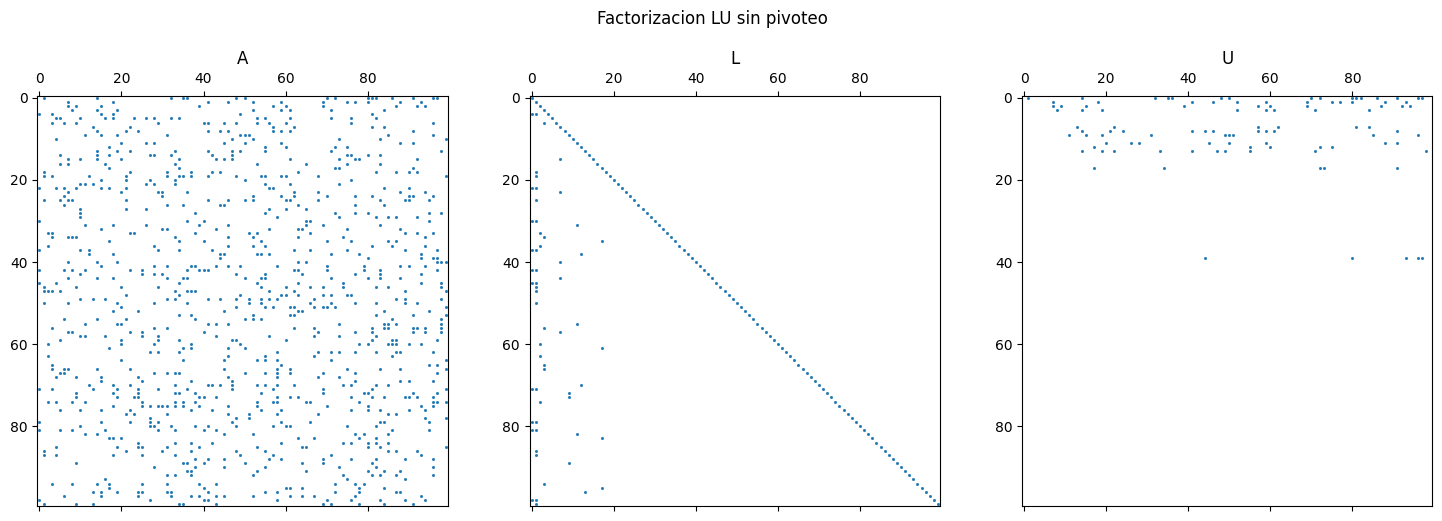

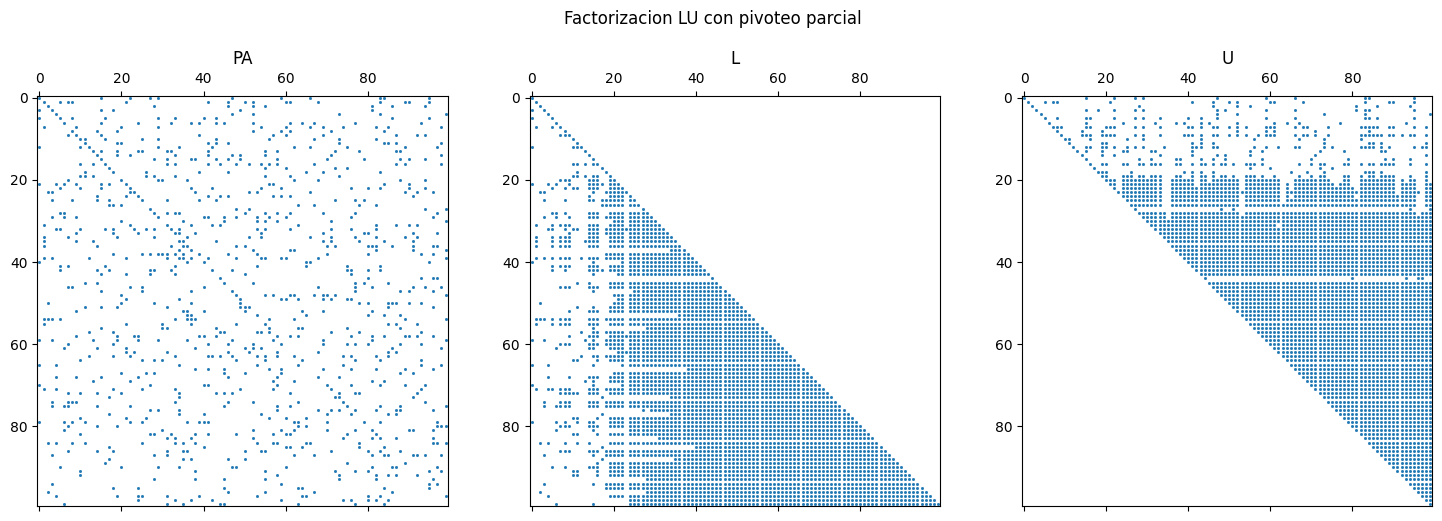

In [15]:
import scipy.sparse as sps

A = sps.random(n, n, density=0.1).todense()

L, U = LUdecomp(A)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Factorizacion LU sin pivoteo")
axs[0].spy(A, markersize=1)
axs[0].set_title("A")
axs[1].spy(L, markersize=1)
axs[1].set_title("L")
axs[2].spy(U, markersize=1)
axs[2].set_title("U")
P, L, U = spl.lu(A)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Factorizacion LU con pivoteo parcial")
axs[0].spy(P.T.dot(A), markersize=1)
axs[0].set_title("PA")
axs[1].spy(L, markersize=1)
axs[1].set_title("L")
axs[2].spy(U, markersize=1)
axs[2].set_title("U")

# 3. Desafío 2.2. libro de O'Leary

Considere el sistema lineal $\mathbf{Ax} = \mathbf{b}$ con 

$$
\mathbf{A} = \begin{bmatrix}
    \delta & 1\\
    1 & 1
\end{bmatrix}, \mathbf{b} = \begin{bmatrix}
    1\\
    0
\end{bmatrix}
$$

y $\delta = 0.002$.

a) Haga un gráfico de las dos ecuaciones definidas por este sistema y compute 
el número de condicionamiento $\kappa(\mathbf{A})$.

b) Compute la solución $\mathbf{x}_{true}$ a $\mathbf{Ax} = \mathbf{b}$ y 
compute la solución a sistemas cercanos $(\mathbf{A} + \Delta 
\mathbf{A}^{(i)})\mathbf{x}^{(i)} = \mathbf{b}$ para 
$i = 1, ..., 1000$, donde los elementos de $\Delta \mathbf{A}^{(i)}$ son 
independientes e idénticamente distribuidos (distribución normal) con 
media 0 y desviación estándar $\tau = 0.0001$. Grafique los 1000 
puntos $(e_1^{(i)}, e_2^{(i)})$ donde $\mathbf{e}^{(i)} = \mathbf{x}^{(i)} - 
\mathbf{x}_{true}$. Luego, grafique los 1000 
residuales $(r_1^{(i)}, r_2^{(i)})$ con $\mathbf{r}^{(i)} = \mathbf{b} - 
\mathbf{A}\mathbf{x}^{(i)}$ (el error backward) para cada una de las 
soluciones computadas.

c) Repita a) y b) con 

$$
\mathbf{A} = \begin{bmatrix}
    1 + \delta & \delta - 1\\
    \delta - 1 & 1 + \delta
\end{bmatrix}, 
\mathbf{b} = \begin{bmatrix}
    2\\
    -2
\end{bmatrix}
$$

d) Discuta sus resultados ¿Por qué los gráficos de los gráficos del error 
forward se ven tan diferentes? ¿Cómo se relaciona el número de condicionamiento 
con lo que ve en los gráficos del error forward? ¿Qué es lo que indican los 
gráficos del error backward?

## Respuesta:

a) Primero graficamos las ecuaciones y el número de condicionamiento para ambos 
problemas (los denominaremos $\mathbf{A}_1$ y $\mathbf{A}_2$ respectivamente)

/var/folders/tk/2_mpyl8j60nc6pfc634c2mc80000gn/T/ipykernel_58685/606692052.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Numero de condicionamiento de A1: 2.6250744562470096
Numero de condicionamiento de A2: 500.0000000000016


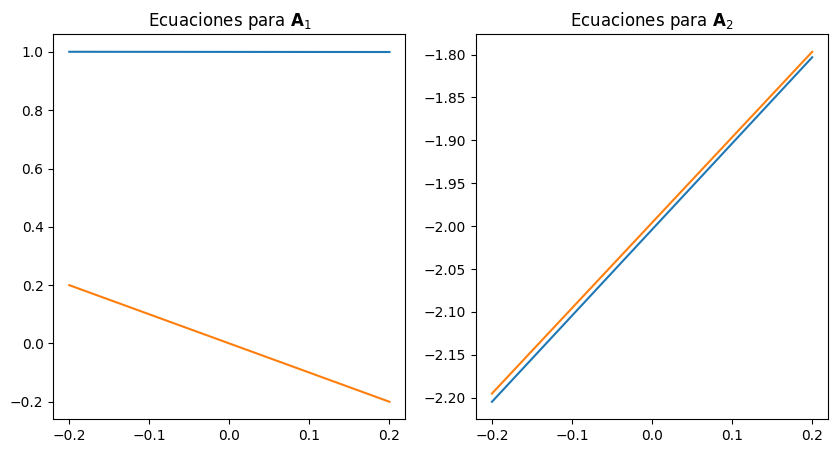

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def get_line(a1, a2, b, x):
    return (b - a1*x)/a2

# data definition
delta = 0.002
A1 = np.array([[delta, 1], 
                [1, 1]])
b1 = np.array([1, 0])

A2 = np.array([[1+delta, delta-1], 
                [delta-1, 1+delta]])

b2 = np.array([2, -2])

# plot equations
x_plot = np.linspace(-0.2, 0.2, num=500)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(x_plot, get_line(A1[0, 0], A1[0, 1], b1[0], x_plot))
axs[0].plot(x_plot, get_line(A1[1, 0], A1[1, 1], b1[1], x_plot))
axs[0].set_title(r"Ecuaciones para $\mathbf{A}_1$")
axs[1].plot(x_plot, get_line(A2[0, 0], A2[0, 1], b2[0], x_plot))
axs[1].plot(x_plot, get_line(A2[1, 0], A2[1, 1], b2[1], x_plot))
axs[1].set_title(r"Ecuaciones para $\mathbf{A}_2$")
fig.show()

# condition number
k1 = np.linalg.cond(A1)
k2 = np.linalg.cond(A2)
print("Numero de condicionamiento de A1:", k1)
print("Numero de condicionamiento de A2:", k2)

Text(0.5, 1.0, 'backward errors para A2')

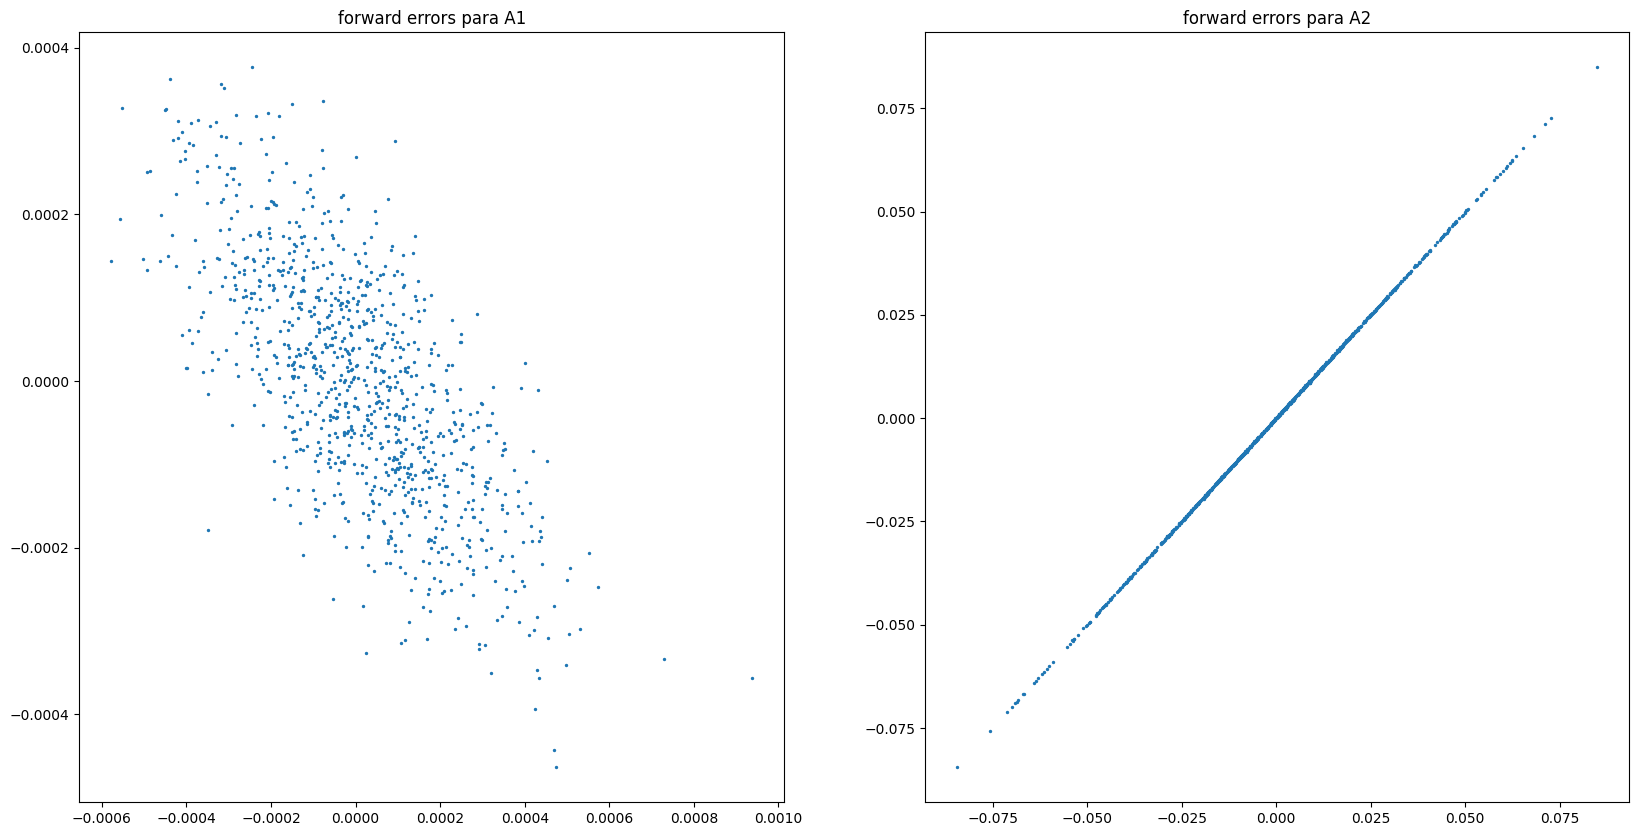

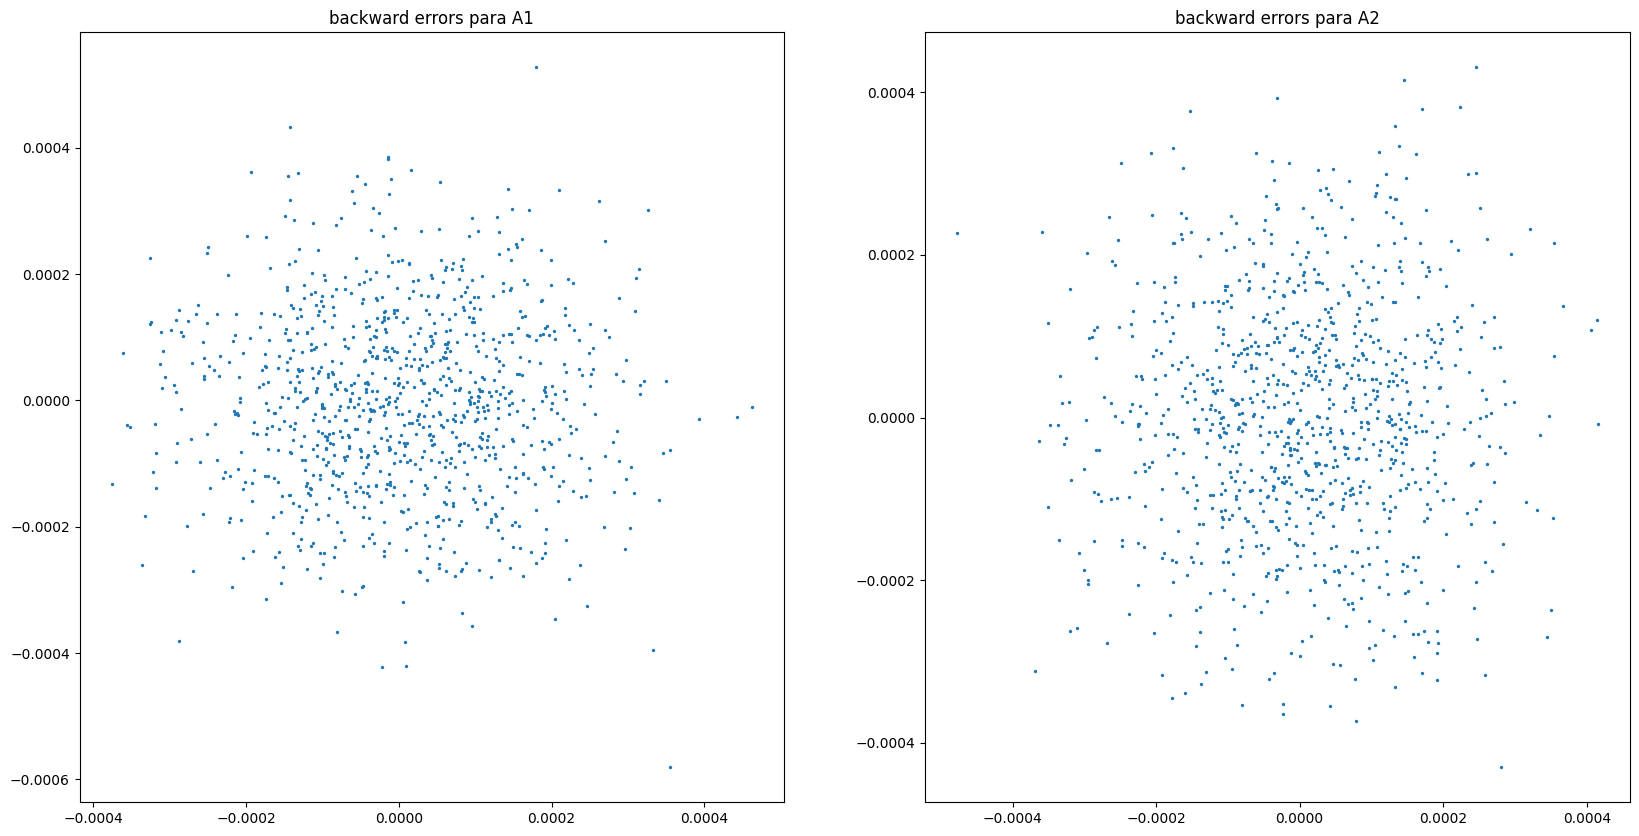

In [14]:
# computation of forward and backward errors
x1_true = np.linalg.solve(A1, b1)
x2_true = np.linalg.solve(A2, b2)
x1_pert = np.zeros((1000, 2))
x2_pert = np.zeros((1000, 2))
fe1 = np.zeros((1000, 2))
fe2 = np.zeros((1000, 2))
be1 = np.zeros((1000, 2))
be2 = np.zeros((1000, 2))
tau = 0.0001
for idx in range(1000):
    x1_pert[idx, :] = np.linalg.solve(A1 + tau*np.random.randn(2, 2), b1)
    x2_pert[idx, :] = np.linalg.solve(A2 + tau*np.random.randn(2, 2), b2)
    fe1[idx, :] = x1_pert[idx, :] - x1_true
    fe2[idx, :] = x2_pert[idx, :] - x2_true
    be1[idx, :] = b1 - A1.dot(x1_pert[idx, :])
    be2[idx, :] = b2 - A2.dot(x2_pert[idx, :])

# plot of forward errors
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(x=fe1[:, 0], y=fe1[:, 1], s=2.0)
axs[0].set_title("forward errors para A1")
axs[1].scatter(x=fe2[:, 0], y=fe2[:, 1], s=2.0)
axs[1].set_title("forward errors para A2")

# plot of backward errors
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(x=be1[:, 0], y=be1[:, 1], s=2.0)
axs[0].set_title("backward errors para A1")
axs[1].scatter(x=be2[:, 0], y=be2[:, 1], s=2.0)
axs[1].set_title("backward errors para A2")